In [1]:
import os
import argparse
import numpy as np
import pandas as pd
import pickle
import copy
import random
import traceback
import time
from tqdm import tqdm

from models.weaksupervision import WeakSupervisionModel
from models.lfgenerator import LFGenerator
from models.activelearning import ActiveLearning
from models.lgbm import LightGBM as EndModel
from sklearn.metrics import average_precision_score, roc_auc_score

from utils import *

import warnings
warnings.filterwarnings("ignore")

In [2]:
def print_p_r(pred_label, train_label_pd):
    precision, recall, f1, tp, tn, fp, fn = point_metrics(
            np.array(pred_label), np.array(train_label_pd))
    print('precision:{}, recall:{}, f1:{}, tp:{}, tn:{}, fp:{}, fn:{}'.format(
            precision, recall, f1, tp, tn, fp, fn))

def plot_exp(end_model_history, snorkel_history, only_end_model_history, uad_score=None, plot_iter=False, plot_auc=False):
    if plot_iter:
        i = 0
        xlabel = 'n_iter'
    else:
        i = 1
        xlabel = 'n_iteraction'

    if plot_auc:
        ylabel = 'ROC AUC'
    else:
        ylabel = 'AP'
        
    plt.plot(np.array(end_model_history)[:,i], np.array(end_model_history)[:,2], label='End-model')
    plt.plot(np.array(snorkel_history)[:,i], np.array(snorkel_history)[:,2], label='Snorkel')
    plt.plot(np.array(only_end_model_history)[:,i], np.array(only_end_model_history)[:,2], label='Golden End Model')
    
    if uad_score:
        for method in uad_score:
            plt.plot([0,len(end_model_history)],[uad_score[method]]*2, label=method)

    plt.legend(loc='lower right')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    plt.close()

def loop(LFs, ts_num = 5):
    global mv_flag, n_iter, n_interact
    print(" *******", n_iter, "th iteration ******* ")

    print("-----WEAK SUPERVISION-----")
    ws_model = WeakSupervisionModel(ws_type, length=LFs.shape[1])
    ws_model.fit(LFs, 0.01, seed=seed)
    ws_score = ws_model.pred_proba(LFs)
    num_ano_gol = (golden_labels.label==1).sum()
    if mv_flag == False:
        pos_thres = max(num_ano_gol*200/N_SAMPLE, ANOMALY_PERCENTAGE*WS_RATIO)
        ws_thres_pos = np.percentile(ws_score, 100 - pos_thres)
        ws_thres_neg = np.percentile(ws_score, pos_thres*N_A_RATIO)
        if ws_thres_pos==1 or ws_thres_neg==0:
            mv_flag = n_iter
        fake_label = ws_model.gen_fake_label(proba_pos = ws_score, proba_neg=ws_score, thres_pos=ws_thres_pos, thres_neg=ws_thres_neg)
    else:
        # majority voting model
        num_ano_ws = int(max(2 * num_ano_gol, N_SAMPLE*ANOMALY_PERCENTAGE*WS_RATIO/100))
        num_nor_ws = int(num_ano_ws*N_A_RATIO)
        sorted_pd = pd.DataFrame((LFs==1).sum(axis=1)-(LFs==0).sum(axis=1)).sort_values(by=0)
        ano_id = sorted_pd[-num_ano_ws:].index
        normal_id = sorted_pd[:num_nor_ws].index
        fake_label=index_pd.copy()
        fake_label[:]=ABSTAIN
        fake_label.loc[ano_id]=1
        fake_label.loc[normal_id]=0
    
    fake_label = adjust_fake_label(fake_label, golden_labels)
 
    # -----------Evaluate ws result--------------------------
    ap = average_precision_score(np.array(train_label_pd), ws_score)
    roc_auc = roc_auc_score(np.array(train_label_pd), ws_score)
    snorkel_ap_history.append([n_iter, n_interact, ap])  
    snorkel_auc_history.append([n_iter, n_interact, roc_auc])  
    print("【AP】:", ap, "【AUC】:", roc_auc)
    # print_p_r(fake_label, train_label_pd)

    print("-----END MODEL-----")
    end_model = EndModel()
    end_model_train_label=fake_label[fake_label.label!=ABSTAIN]
    end_model_train_label_index=end_model_train_label.index
    end_model.train(train_features.loc[end_model_train_label_index], end_model_train_label)
    end_model_pred = end_model.predict(train_features)
    end_model_pred_label = index_pd.copy()
    end_model_pred_label[:] = end_model_pred > np.percentile(end_model_pred, NORMAL_PERCENTAGE)
    
    # -----------Evaluate End Model--------------------------
    ap = average_precision_score(np.array(train_label_pd), np.array(end_model_pred))
    roc_auc = roc_auc_score(np.array(train_label_pd), np.array(end_model_pred))
    end_model_ap_history.append([n_iter, n_interact, ap])
    end_model_auc_history.append([n_iter, n_interact, roc_auc])
    print("TRAIN【AP】:", ap, "【AUC】:", roc_auc)
    # print_p_r(end_model_pred_label, train_label_pd)
    end_model_pred_test = end_model.predict(test_features)
    ap = average_precision_score(np.array(test_label_pd), np.array(end_model_pred_test))
    roc_auc = roc_auc_score(np.array(test_label_pd), np.array(end_model_pred_test))
    end_model_test_ap_history.append([n_iter, n_interact, ap])
    end_model_test_auc_history.append([n_iter, n_interact, roc_auc])
    print("TEST 【AP】:", ap, "【AUC】:", roc_auc)

    print("-----ACTIVE LEARNING-----")
    if wo_active_learning:
        top_k = active_learning.get_next_sample_random(golden_labels, ts_num = ts_num)
        print("Random AL")
    else:
        # calculate uncertainty
        active_learning.cal_uncertainty(end_model_pred, LFs, ts2vec, golden_labels)
        top_k = active_learning.get_next_sample(golden_labels, ts_num = ts_num, len_padding=LEN_PADDING)
    print("Top", ts_num, top_k)

    print("-----HUMAN LABELING-----")
    for sample_key, sample_index in top_k:
        if golden_labels.loc[sample_key].iloc[sample_index].item() != -1:
            continue
        arr = train_data[sample_key]
        label_pd = train_labels[sample_key]
        l = max(0, sample_index - LEN_PADDING)
        r = min(len(arr), sample_index + LEN_PADDING)
        sample_arr = arr[l:r]
        sample_labels = label_pd.iloc[l:r]
        golden_labels.loc[sample_key].iloc[l:r] = sample_labels
        n_interact += 1
        num_anomaly = sample_labels.sum().item()
        if num_anomaly==0:
            print("No anomaly is annotated in", sample_key, sample_index, )
        else:
            print(num_anomaly, "anomalies are labeled in", sample_key, sample_index)
            break
    n_iter += 1
    
    print("-----GOLDEN LABEL MODEL-----")
    only_end_model_train_label=golden_labels[golden_labels.label!=-1]
    num_labeled_anomaly = int((only_end_model_train_label==1).sum())
    labeled_percentage = round(num_labeled_anomaly/NUM_ANOMALY*100, 3)
    print("Up to now labeled",num_labeled_anomaly , "anomaly (", labeled_percentage, "%)")
    only_end_model_train_data=train_features.loc[only_end_model_train_label.index]
    only_end_model = EndModel()
    only_end_model.train(np.array(only_end_model_train_data), np.array(only_end_model_train_label))
    only_end_model_pred = only_end_model.predict(train_features)
    only_end_model_pred_label = index_pd.copy()
    only_end_model_pred_label[:] = only_end_model_pred >= np.percentile(only_end_model_pred, NORMAL_PERCENTAGE)
    
    # -----------Evaluate Golden Label End Model--------------------------
    ap = average_precision_score(np.array(train_label_pd), np.array(only_end_model_pred))
    auc = roc_auc_score(np.array(train_label_pd), np.array(only_end_model_pred))
    only_end_model_ap_history.append([n_iter, n_interact, ap])
    only_end_model_auc_history.append([n_iter, n_interact, auc])
    print("TRAIN【AP】:", ap, "【AUC】:", auc)
    only_end_model_pred_test = only_end_model.predict(test_features)
    ap = average_precision_score(np.array(test_label_pd), np.array(only_end_model_pred_test))
    auc = roc_auc_score(np.array(test_label_pd), np.array(only_end_model_pred_test))
    only_end_model_test_ap_history.append([n_iter, n_interact, ap])
    only_end_model_test_auc_history.append([n_iter, n_interact, auc])
    print("TEST 【AP】:", ap, "【AUC】:", auc)

    # adding golden end model label to LF on intervals
    if n_iter % 5==0:
        end_pred = index_pd.copy()
        end_pred[:] = only_end_model_pred
        pos_thr = np.percentile(end_pred, 100 - ANOMALY_PERCENTAGE/2)
        neg_thr = np.percentile(end_pred, NORMAL_PERCENTAGE/2)
        pred = index_pd.copy()
        pred[:] = -1
        pred[end_pred >= pos_thr] = 1
        pred[end_pred <= neg_thr] = 0
        pred.columns = [f'End_{n_iter}']
        # print_p_r(pred, train_label_pd)
        pred = pred.astype(int)
        LFs = pd.concat([LFs, pred], axis=1)
        
    print("-----LF GENERATOR-----")
    anomaly_index = (np.where(sample_labels==1)[0] + sample_labels.index[0]).tolist()
    not_anomaly_index = (np.where(sample_labels==0)[0] + sample_labels.index[0]).tolist()

    if wo_lf_generator:
        pred = index_pd.copy()
        pred[:] = -1
        pred.loc[sample_key].iloc[l:r] = sample_labels
        pred.columns = [f'l_{n_iter}']
        pred = pred.astype(int)
        LFs = pd.concat([LFs, pred], axis=1)
        print("w/o LF Generator")
        return LFs

    # LFG
    if anomaly_index != []:
        # truncate, to save time
        if len(anomaly_index) > 100:
            anomaly_index = random.sample(anomaly_index, 100)

        # run ts2vec
        if use_t2v:
            pred_dict_t2v = {}
            for index in anomaly_index:
                t2v_pred = ts2vec.predict(sample_key, index)
                t2v_pred = t2v_pred.astype(int)
                pred_dict_t2v[index] = t2v_pred
            if len(pred_dict_t2v) == 0:
                pred = copy.deepcopy(index_pd)
                pred[:] = ABSTAIN    
            else:
                pred_sum = pd.DataFrame.from_dict(pred_dict_t2v)
                pred_sum = pred_sum.sum(axis=1)
                
                pred = pred_sum > -len(pred_dict_t2v)
                pred_int = np.zeros_like(pred).astype(int)
                pred_int[pred==True] = 1
                pred_int[pred==False] = ABSTAIN
                pred = index_pd.copy()
                pred[:] = pred_int[:,np.newaxis]     

            pred.loc[sample_key].iloc[anomaly_index] = 1
            pred.loc[sample_key].iloc[not_anomaly_index] = 0
                    
            print("Ts2vec labeled",(pred.label==1).sum() , "anomaly.")
            # print_p_r(pred, train_label_pd)

            pred.columns = [f't2v_{n_iter}']
            pred = pred.astype(int)
            LFs = pd.concat([LFs, pred], axis=1)

        # run statistic model
        if use_stat:
            pred_dict_stat = {}
            for index in anomaly_index:
                # print(sample_key, index)
                static_pred = statistic_model.predict(sample_key, index)
                static_pred = static_pred.astype(int)
                pred_dict_stat[index] = static_pred
            if len(pred_dict_stat) == 0:
                pred = copy.deepcopy(index_pd)
                pred[:] = ABSTAIN    
            else:
                pred_sum = pd.DataFrame.from_dict(pred_dict_stat)
                pred_sum = pred_sum.sum(axis=1)
                pred = pred_sum > -len(pred_dict_stat)
                pred_int = np.zeros_like(pred).astype(int)
                pred_int[pred==True] = 1
                pred_int[pred==False] = ABSTAIN
                pred = index_pd.copy()
                pred[:] = pred_int[:,np.newaxis]     
            pred.loc[sample_key].iloc[anomaly_index] = 1
            pred.loc[sample_key].iloc[not_anomaly_index] = 0
            print("Statistic model labeled",(pred.label==1).sum() , "anomaly")
            # print_p_r(pred, train_label_pd)

            # Denoise
            if not use_uad:
                ws_filter = ws_score>ws_score.mean()
                filter_percent = ((ws_filter).sum().item()/len(ws_filter))*100
                filtered_num = len(pred.loc[(pred.label==1) & (ws_filter.score==0)])
                pred.loc[(pred.label==1) & (ws_filter.score==0)] = -1
                print('Weak model filted:', filtered_num, 'anomaly not in top', round(filter_percent,2), '%')
            # print_p_r(pred, train_label_pd)
            pred.columns = [f'stat_{n_iter}']
            pred = pred.astype(int)
            LFs = pd.concat([LFs, pred], axis=1)

        # run ScaNN
        if use_scann:
            queries = train_repr.loc[sample_key].iloc[anomaly_index]
            neighbors, distances = searcher.search_batched(queries)
            pred = index_pd.copy()
            pred[:] = -1
            for neighbor in neighbors:
                pred.iloc[neighbor] = 1
            pred.loc[sample_key].iloc[anomaly_index] = 1
            pred.loc[sample_key].iloc[not_anomaly_index] = 0
            print("Scann labeled",(pred.label==1).sum() , "anomaly")
            # print_p_r(pred, train_label_pd)

            # Denoise
            if not use_uad:
                ws_filter = ws_score>ws_score.mean()
                filter_percent = ((ws_filter).sum().item()/len(ws_filter))*100
                filtered_num = len(pred.loc[(pred.label==1) & (ws_filter.score==0)])
                pred.loc[(pred.label==1) & (ws_filter.score==0)] = -1
                print('Weak model filted:', filtered_num, 'anomaly not in top', round(filter_percent,2), '%')
            # print_p_r(pred, train_label_pd)
            pred.columns = [f'scann_{n_iter}']
            pred = pred.astype(int)
            LFs = pd.concat([LFs, pred], axis=1)

    return LFs   

# Experiment Setup

In [3]:
dataset='yahoo'

seed = 123

ws_type = 'snorkel'
use_uad = True
use_t2v = True
use_stat = True
use_scann = False

wo_active_learning = False
wo_lf_generator = False

ABSTAIN = -1

# Hyper-parameters
WS_RATIO = 0.1
LEN_PADDING = 200
SCANN_NUM = 200
ANOMALY_PERCENTAGE = 1
UAD_POS_THR = 0.95
UAD_NEG_THR = 0.05
N_A_RATIO = 100/ANOMALY_PERCENTAGE
NORMAL_PERCENTAGE = 100 - ANOMALY_PERCENTAGE

# Load Data

In [4]:
# Load data
train_data, train_labels, train_timestamps, test_data, test_labels, test_timestamps = load_anomaly(dataset)
train_label_pd = merge_all_arrays(train_labels)
train_label_pd.columns = ['label']
test_label_pd = merge_all_arrays(test_labels)
test_label_pd.columns = ['label']
print("Load dataset done!")

N_SAMPLE = len(train_label_pd)
NUM_ANOMALY = int(train_label_pd.sum())

# empty index
index_pd = copy.deepcopy(train_label_pd)
index_pd[:]=ABSTAIN

# load preprocesed features
with open(f"data/data_preprocessed/{dataset}/{dataset}_train_features.pkl", 'rb') as f:
    train_features = pickle.load(f)
with open(f"data/data_preprocessed/{dataset}/{dataset}_test_features.pkl", 'rb') as f:
    test_features = pickle.load(f)
print("Load DNN features done!")
    
# load uads
if use_uad:
    with open(f"data/data_preprocessed/{dataset}/{dataset}_uad_train_score.pkl", 'rb') as f:
        uad_score = pickle.load(f)
        uad_score = uad_score.fillna(0)
    print("Load uad labels done!")
    anomaly_prob_init = uad_score.sum(axis=1)*0.2
else: 
    anomaly_prob_init = index_pd.copy()

Load dataset done!
Load DNN features done!
Load uad labels done!


# Instantiate Module

In [5]:
# Initiate LFGenerator
ts2vec = LFGenerator(dataset=dataset)
if use_stat:
    statistic_model = LFGenerator(dataset=dataset, model='dnn_features')
if use_scann:
    # Scann
    import scann
    with open(f"data/ts2vec/{dataset}/{dataset}_train_repr.pkl", 'rb') as f:
        train_repr = pickle.load(f)
    
    searcher = scann.scann_ops_pybind.builder(train_repr, SCANN_NUM, "dot_product").tree(
        num_leaves=2000, num_leaves_to_search=100, training_sample_size=250000).score_ah(
        2, anisotropic_quantization_threshold=0.2).reorder(5000).build()
    print("Scann ready!")

# init Active Learning
active_learning = ActiveLearning(anomaly_prob_init)

Ts2Vec model ready!
Statistic model ready!
Active learning model ready!


# Reset Experiment

In [6]:
# init golden labels
golden_labels = index_pd.copy()
golden_labels[:] = ABSTAIN

# flag for changing ws model from snorkel to majority voting
mv_flag = False
n_iter = 0
n_interact = 0

# history record
snorkel_ap_history = []
snorkel_auc_history=[]
end_model_ap_history = []
end_model_auc_history=[]
only_end_model_ap_history = []
only_end_model_auc_history=[]
end_model_test_ap_history = []
end_model_test_auc_history=[]
only_end_model_test_ap_history = []
only_end_model_test_auc_history=[]

# init labeling functions, start from UAD labels
uad_labels = uad_score.copy()
uad_labels[:] = ABSTAIN

for method in uad_score.columns:
    uad_score[method] = min_max_normalize(uad_score[method])
uad_labels[uad_score > UAD_POS_THR] = 1
uad_labels[uad_score < UAD_NEG_THR] = 0
LFs = uad_labels.copy()
LFs = pd.DataFrame(LFs).astype(int)

# calculate ts2vec label as a UAD
t2v_mean_repr=ts2vec.all_repr.mean()
t2v_uad_score=np.abs(ts2vec.all_repr - t2v_mean_repr).sum(axis=1)
max_limit = np.percentile(t2v_uad_score,99.9)
t2v_uad_score[t2v_uad_score>max_limit]=max_limit
t2v_uad_score = min_max_normalize(t2v_uad_score)
t2v_uad_pred_label=index_pd.copy()
t2v_uad_pred_label[:]=-1
t2v_uad_pred_label[t2v_uad_score > UAD_POS_THR] = 1
t2v_uad_pred_label[t2v_uad_score < UAD_NEG_THR] = 0
t2v_uad_pred_label.columns = ['ts2vec']
t2v_uad_pred_label = t2v_uad_pred_label.astype(int)
LFs = pd.concat([LFs, t2v_uad_pred_label], axis=1)

In [7]:
LFs_init = LFs.copy()

In [8]:
# eval uads
uad_ap_dict = dict()
# if use_uad:
for method in uad_score.columns:   
    method_ = method.split('_')[0]
    print(method_)          
    ap = average_precision_score(np.array(train_label_pd), np.array(uad_score[method]))
    uad_ap_dict[method_] = ap
    print('ap:', ap)
    print_p_r(LFs[method], train_label_pd.label)

# Ts2vec
print('ts2vec')
ap = average_precision_score(np.array(train_label_pd), np.array(t2v_uad_score))
uad_ap_dict['ts2vec'] = ap
print('ap:', ap)
print_p_r(t2v_uad_pred_label.ts2vec, train_label_pd.label)

iforest
ap: 0.2129470480334371
precision:0.48051948047787707, recall:0.6793145654003288, f1:0.5628802759554186, tp:555, tn:144520, fp:600, fn:262
sr
ap: 0.2656523813112721
precision:0.8176638174308649, recall:0.3756544502126107, f1:0.514798163045631, tp:287, tn:138030, fp:64, fn:477
stl
ap: 0.20169187737141492
precision:0.6655518393535866, recall:0.8308977033755954, f1:0.7390900154685361, tp:398, tn:116634, fp:200, fn:81
lumino
ap: 0.3619133471139391
precision:0.8261904759937642, recall:0.39164785548627, f1:0.5313935244314767, tp:347, tn:266715, fp:73, fn:539
rcforest
ap: 0.20338651003478211
precision:0.623493975715815, recall:0.22234156818234785, f1:0.32779093506632045, tp:207, tn:324651, fp:125, fn:724
ts2vec
ap: 0.36655578957957846
precision:0.8982683980739679, recall:0.8645833331532118, f1:0.8811039838014643, tp:415, tn:99588, fp:47, fn:65


In [9]:
num_epoch = 100

for i in range(num_epoch):
    LFs = loop(LFs)

 ******* 0 th iteration ******* 
-----WEAK SUPERVISION-----
【AP】: 0.30437473260073206 【AUC】: 0.8805199315802117
-----END MODEL-----
TRAIN【AP】: 0.0974837490187023 【AUC】: 0.903190324818163
TEST 【AP】: 0.09411495147631874 【AUC】: 0.8926393575522342
-----ACTIVE LEARNING-----
Top 5 [('yahoo_174', 1202), ('yahoo_263', 727), ('yahoo_264', 1200), ('yahoo_182', 970), ('yahoo_360', 791)]
-----HUMAN LABELING-----
6 anomalies are labeled in yahoo_174 1202
-----GOLDEN LABEL MODEL-----
Up to now labeled 6 anomaly ( 0.209 %)
TRAIN【AP】: 0.3752251225303978 【AUC】: 0.865047257722143
TEST 【AP】: 0.2876397192952102 【AUC】: 0.7721305863890149
-----LF GENERATOR-----
Ts2vec labeled 6 anomaly.
Statistic model labeled 576 anomaly
 ******* 1 th iteration ******* 
-----WEAK SUPERVISION-----
【AP】: 0.33174184368751186 【AUC】: 0.8811511107005664
-----END MODEL-----
TRAIN【AP】: 0.13625007834353917 【AUC】: 0.9109003447889279
TEST 【AP】: 0.10166292582475438 【AUC】: 0.8788411961835367
-----ACTIVE LEARNING-----
Top 5 [('yahoo_63'

Top 5 [('yahoo_270', 1654), ('yahoo_270', 1652), ('yahoo_176', 1576), ('yahoo_324', 363), ('yahoo_270', 1651)]
-----HUMAN LABELING-----
No anomaly is annotated in yahoo_270 1654
2 anomalies are labeled in yahoo_176 1576
-----GOLDEN LABEL MODEL-----
Up to now labeled 68 anomaly ( 2.364 %)
TRAIN【AP】: 0.5559758696698334 【AUC】: 0.884545156060123
TEST 【AP】: 0.4395699436564513 【AUC】: 0.8627473853445008
-----LF GENERATOR-----
Ts2vec labeled 2 anomaly.
Statistic model labeled 483 anomaly
 ******* 12 th iteration ******* 
-----WEAK SUPERVISION-----
【AP】: 0.4904148650940376 【AUC】: 0.9131591010715121
-----END MODEL-----
TRAIN【AP】: 0.5720300328595341 【AUC】: 0.867139639777615
TEST 【AP】: 0.49405769690814344 【AUC】: 0.8779724543451557
-----ACTIVE LEARNING-----
Top 5 [('yahoo_255', 1564), ('yahoo_60', 860), ('yahoo_44', 1460), ('yahoo_205', 1068), ('yahoo_316', 676)]
-----HUMAN LABELING-----
1 anomalies are labeled in yahoo_255 1564
-----GOLDEN LABEL MODEL-----
Up to now labeled 69 anomaly ( 2.398 %)
T

TRAIN【AP】: 0.5994163195944804 【AUC】: 0.8890692181056497
TEST 【AP】: 0.4692170965414211 【AUC】: 0.9113333734561317
-----LF GENERATOR-----
Ts2vec labeled 2 anomaly.
Statistic model labeled 83 anomaly
 ******* 23 th iteration ******* 
-----WEAK SUPERVISION-----
【AP】: 0.5394442131684533 【AUC】: 0.9356392366297122
-----END MODEL-----
TRAIN【AP】: 0.6279901722871527 【AUC】: 0.9344093586737707
TEST 【AP】: 0.5302415661267507 【AUC】: 0.9158861266246281
-----ACTIVE LEARNING-----
Top 5 [('yahoo_185', 451), ('yahoo_275', 260), ('yahoo_323', 8), ('yahoo_118', 491), ('yahoo_232', 330)]
-----HUMAN LABELING-----
1 anomalies are labeled in yahoo_185 451
-----GOLDEN LABEL MODEL-----
Up to now labeled 114 anomaly ( 3.962 %)
TRAIN【AP】: 0.5837099503999146 【AUC】: 0.9013593934698332
TEST 【AP】: 0.47735404792999947 【AUC】: 0.8848729496153491
-----LF GENERATOR-----
Ts2vec labeled 1 anomaly.
Statistic model labeled 405 anomaly
 ******* 24 th iteration ******* 
-----WEAK SUPERVISION-----
【AP】: 0.5393832896785921 【AUC】: 0.

Ts2vec labeled 44 anomaly.
Statistic model labeled 580 anomaly
 ******* 34 th iteration ******* 
-----WEAK SUPERVISION-----
【AP】: 0.5398257935583324 【AUC】: 0.947679034166887
-----END MODEL-----
TRAIN【AP】: 0.6603212516475878 【AUC】: 0.899083560923583
TEST 【AP】: 0.5528051233625917 【AUC】: 0.9130943230138687
-----ACTIVE LEARNING-----
Top 5 [('yahoo_4', 119), ('yahoo_27', 119), ('yahoo_273', 35), ('yahoo_35', 1336), ('yahoo_295', 1371)]
-----HUMAN LABELING-----
1 anomalies are labeled in yahoo_4 119
-----GOLDEN LABEL MODEL-----
Up to now labeled 178 anomaly ( 6.187 %)
TRAIN【AP】: 0.6169394952649412 【AUC】: 0.9052688826472461
TEST 【AP】: 0.49742681597211313 【AUC】: 0.8875839120140059
-----LF GENERATOR-----
Ts2vec labeled 1 anomaly.
Statistic model labeled 291 anomaly
 ******* 35 th iteration ******* 
-----WEAK SUPERVISION-----
【AP】: 0.5415465767806537 【AUC】: 0.9506108333115877
-----END MODEL-----
TRAIN【AP】: 0.641352577483545 【AUC】: 0.8601378738469242
TEST 【AP】: 0.5347108353723329 【AUC】: 0.8593552

Top 5 [('yahoo_323', 771), ('yahoo_341', 956), ('yahoo_118', 1294), ('yahoo_178', 175), ('yahoo_60', 654)]
-----HUMAN LABELING-----
No anomaly is annotated in yahoo_323 771
2 anomalies are labeled in yahoo_341 956
-----GOLDEN LABEL MODEL-----
Up to now labeled 351 anomaly ( 12.2 %)
TRAIN【AP】: 0.7065717946694358 【AUC】: 0.9475062458587044
TEST 【AP】: 0.5744518951887156 【AUC】: 0.9476479918052026
-----LF GENERATOR-----
Ts2vec labeled 2 anomaly.
Statistic model labeled 396 anomaly
 ******* 46 th iteration ******* 
-----WEAK SUPERVISION-----
【AP】: 0.5750541966511595 【AUC】: 0.9621162155862708
-----END MODEL-----
TRAIN【AP】: 0.6419055811135026 【AUC】: 0.939836142907009
TEST 【AP】: 0.5716422994418581 【AUC】: 0.9431362514736736
-----ACTIVE LEARNING-----
Top 5 [('yahoo_185', 788), ('yahoo_2', 854), ('yahoo_367', 1059), ('yahoo_225', 1628), ('yahoo_359', 1315)]
-----HUMAN LABELING-----
4 anomalies are labeled in yahoo_185 788
-----GOLDEN LABEL MODEL-----
Up to now labeled 355 anomaly ( 12.339 %)
TRAIN【

TEST 【AP】: 0.6120103496799116 【AUC】: 0.9592021191660112
-----LF GENERATOR-----
Ts2vec labeled 1 anomaly.
Statistic model labeled 63 anomaly
 ******* 57 th iteration ******* 
-----WEAK SUPERVISION-----
【AP】: 0.5821135265941484 【AUC】: 0.9680676614245364
-----END MODEL-----
TRAIN【AP】: 0.6659562830594526 【AUC】: 0.9493929134444173
TEST 【AP】: 0.6259567425694623 【AUC】: 0.9544010046564646
-----ACTIVE LEARNING-----
Top 5 [('yahoo_300', 621), ('yahoo_307', 935), ('yahoo_34', 1375), ('yahoo_348', 956), ('yahoo_83', 1248)]
-----HUMAN LABELING-----
1 anomalies are labeled in yahoo_300 621
-----GOLDEN LABEL MODEL-----
Up to now labeled 382 anomaly ( 13.278 %)
TRAIN【AP】: 0.7170760168723285 【AUC】: 0.9336342255666986
TEST 【AP】: 0.6045374241570872 【AUC】: 0.9379981541888283
-----LF GENERATOR-----
Ts2vec labeled 1 anomaly.
Statistic model labeled 157 anomaly
 ******* 58 th iteration ******* 
-----WEAK SUPERVISION-----
【AP】: 0.5821504285946115 【AUC】: 0.9681017930897428
-----END MODEL-----
TRAIN【AP】: 0.6729

TRAIN【AP】: 0.6869072795915139 【AUC】: 0.9342629724086062
TEST 【AP】: 0.6177246035941375 【AUC】: 0.9138184386784212
-----ACTIVE LEARNING-----
Top 5 [('yahoo_60', 691), ('yahoo_361', 385), ('yahoo_28', 1287), ('yahoo_121', 963), ('yahoo_53', 1060)]
-----HUMAN LABELING-----
No anomaly is annotated in yahoo_60 691
2 anomalies are labeled in yahoo_361 385
-----GOLDEN LABEL MODEL-----
Up to now labeled 429 anomaly ( 14.911 %)
TRAIN【AP】: 0.7342325813587927 【AUC】: 0.9523016145341611
TEST 【AP】: 0.6231123598702589 【AUC】: 0.9308046264456458
-----LF GENERATOR-----
Ts2vec labeled 2 anomaly.
Statistic model labeled 412 anomaly
 ******* 69 th iteration ******* 
-----WEAK SUPERVISION-----
【AP】: 0.587112273467651 【AUC】: 0.9747189739101295
-----END MODEL-----
TRAIN【AP】: 0.6863887256257265 【AUC】: 0.9546570426358171
TEST 【AP】: 0.6064295039314066 【AUC】: 0.9582297436857083
-----ACTIVE LEARNING-----
Top 5 [('yahoo_225', 1628), ('yahoo_320', 452), ('yahoo_359', 1317), ('yahoo_314', 1228), ('yahoo_131', 895)]
---

TRAIN【AP】: 0.7682505932842706 【AUC】: 0.963850741005369
TEST 【AP】: 0.6279180339891817 【AUC】: 0.9388117880944449
-----LF GENERATOR-----
Ts2vec labeled 5 anomaly.
Statistic model labeled 334 anomaly
 ******* 80 th iteration ******* 
-----WEAK SUPERVISION-----
【AP】: 0.5935227841601317 【AUC】: 0.9789575381713582
-----END MODEL-----
TRAIN【AP】: 0.7679268938131958 【AUC】: 0.9659868054891104
TEST 【AP】: 0.5850275116715926 【AUC】: 0.9689761188399388
-----ACTIVE LEARNING-----
Top 5 [('yahoo_22', 0), ('yahoo_52', 1101), ('yahoo_25', 1314), ('yahoo_200', 1368), ('yahoo_89', 662)]
-----HUMAN LABELING-----
No anomaly is annotated in yahoo_22 0
3 anomalies are labeled in yahoo_52 1101
-----GOLDEN LABEL MODEL-----
Up to now labeled 540 anomaly ( 18.77 %)
TRAIN【AP】: 0.78240408974377 【AUC】: 0.9669755745378757
TEST 【AP】: 0.6516853169110168 【AUC】: 0.9534473402889263
-----LF GENERATOR-----
Ts2vec labeled 3 anomaly.
Statistic model labeled 329 anomaly
 ******* 81 th iteration ******* 
-----WEAK SUPERVISION-----


TRAIN【AP】: 0.8156943410513527 【AUC】: 0.972188386171977
TEST 【AP】: 0.6736708679664015 【AUC】: 0.966172484147569
-----LF GENERATOR-----
Ts2vec labeled 156 anomaly.
Statistic model labeled 567 anomaly
 ******* 92 th iteration ******* 
-----WEAK SUPERVISION-----
【AP】: 0.5972143595611544 【AUC】: 0.9802722611662755
-----END MODEL-----
TRAIN【AP】: 0.7668611025938489 【AUC】: 0.9725343014910927
TEST 【AP】: 0.6323943169899316 【AUC】: 0.9707928294765361
-----ACTIVE LEARNING-----
Top 5 [('yahoo_295', 1540), ('yahoo_227', 1446), ('yahoo_31', 1397), ('yahoo_31', 1398), ('yahoo_50', 178)]
-----HUMAN LABELING-----
No anomaly is annotated in yahoo_295 1540
4 anomalies are labeled in yahoo_227 1446
-----GOLDEN LABEL MODEL-----
Up to now labeled 609 anomaly ( 21.168 %)
TRAIN【AP】: 0.8121652799872795 【AUC】: 0.9763323885522815
TEST 【AP】: 0.6866345305746754 【AUC】: 0.9702304503830157
-----LF GENERATOR-----
Ts2vec labeled 4 anomaly.
Statistic model labeled 630 anomaly
 ******* 93 th iteration ******* 
-----WEAK SUPE

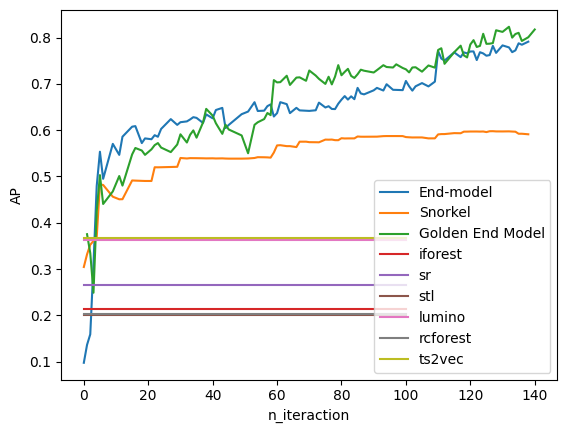

In [10]:
# Train
plot_exp(end_model_ap_history, snorkel_ap_history, only_end_model_ap_history, uad_ap_dict)

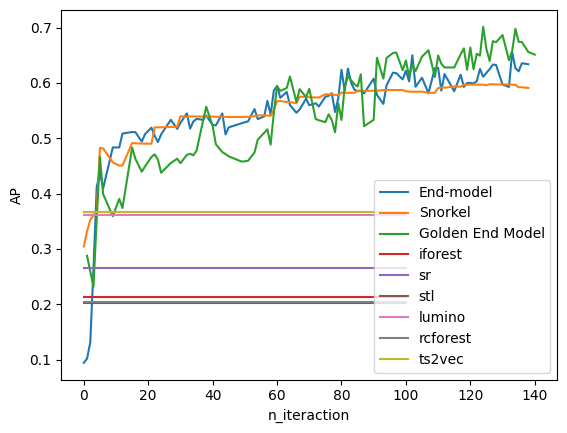

In [11]:
# Test
plot_exp(end_model_test_ap_history, snorkel_ap_history, only_end_model_test_ap_history, uad_ap_dict)

# Ablation: Active Learning

In [12]:
wo_active_learning = True

# init golden labels
golden_labels = index_pd.copy()
golden_labels[:] = ABSTAIN

# flag for changing ws model from snorkel to majority voting
mv_flag = False
n_iter = 0
n_interact = 0

# history record
snorkel_ap_history = []
snorkel_auc_history=[]
end_model_ap_history = []
end_model_auc_history=[]
only_end_model_ap_history = []
only_end_model_auc_history=[]
end_model_test_ap_history = []
end_model_test_auc_history=[]
only_end_model_test_ap_history = []
only_end_model_test_auc_history=[]

LFs = LFs_init.copy()

In [13]:
num_epoch = 100

for i in range(num_epoch):
    LFs = loop(LFs)

 ******* 0 th iteration ******* 
-----WEAK SUPERVISION-----
【AP】: 0.30437473260073206 【AUC】: 0.8805199315802117
-----END MODEL-----
TRAIN【AP】: 0.0974837490187023 【AUC】: 0.903190324818163
TEST 【AP】: 0.09411495147631874 【AUC】: 0.8926393575522342
-----ACTIVE LEARNING-----
Random AL
Top 5 [('yahoo_243', 472), ('yahoo_73', 606), ('yahoo_217', 1050), ('yahoo_244', 1490), ('yahoo_220', 1543)]
-----HUMAN LABELING-----
2 anomalies are labeled in yahoo_243 472
-----GOLDEN LABEL MODEL-----
Up to now labeled 2 anomaly ( 0.07 %)
TRAIN【AP】: 0.08635416941090583 【AUC】: 0.8044219029964617
TEST 【AP】: 0.09104594176231187 【AUC】: 0.7972522367106496
-----LF GENERATOR-----
Ts2vec labeled 2 anomaly.
Statistic model labeled 522 anomaly
 ******* 1 th iteration ******* 
-----WEAK SUPERVISION-----
【AP】: 0.3321979668169662 【AUC】: 0.8814540402227942
-----END MODEL-----
TRAIN【AP】: 0.27253366283041613 【AUC】: 0.9060893041572232
TEST 【AP】: 0.23986656291146516 【AUC】: 0.9047740911820648
-----ACTIVE LEARNING-----
Random A

【AP】: 0.4826866097204604 【AUC】: 0.9264214560037334
-----END MODEL-----
TRAIN【AP】: 0.5377551795896107 【AUC】: 0.8711517366625189
TEST 【AP】: 0.4674456533818572 【AUC】: 0.8842777372398535
-----ACTIVE LEARNING-----
Random AL
Top 5 [('yahoo_303', 762), ('yahoo_71', 670), ('yahoo_83', 372), ('yahoo_110', 339), ('yahoo_179', 1661)]
-----HUMAN LABELING-----
3 anomalies are labeled in yahoo_303 762
-----GOLDEN LABEL MODEL-----
Up to now labeled 61 anomaly ( 2.12 %)
TRAIN【AP】: 0.4572329309270378 【AUC】: 0.8485141734567405
TEST 【AP】: 0.37847907065227054 【AUC】: 0.8382384368233509
-----LF GENERATOR-----
Ts2vec labeled 3 anomaly.
Statistic model labeled 625 anomaly
 ******* 12 th iteration ******* 
-----WEAK SUPERVISION-----
【AP】: 0.48030245848442954 【AUC】: 0.9265210374757806
-----END MODEL-----
TRAIN【AP】: 0.5052924486988327 【AUC】: 0.9087196304469596
TEST 【AP】: 0.443827562365437 【AUC】: 0.8963898408803451
-----ACTIVE LEARNING-----
Random AL
Top 5 [('yahoo_112', 526), ('yahoo_116', 733), ('yahoo_224', 10

TRAIN【AP】: 0.503388759056002 【AUC】: 0.8999424816461887
TEST 【AP】: 0.5183019858181378 【AUC】: 0.9305272694789554
-----ACTIVE LEARNING-----
Random AL
Top 5 [('yahoo_47', 62), ('yahoo_27', 233), ('yahoo_208', 306), ('yahoo_87', 147), ('yahoo_348', 227)]
-----HUMAN LABELING-----
No anomaly is annotated in yahoo_47 62
No anomaly is annotated in yahoo_27 233
No anomaly is annotated in yahoo_208 306
No anomaly is annotated in yahoo_87 147
1 anomalies are labeled in yahoo_348 227
-----GOLDEN LABEL MODEL-----
Up to now labeled 196 anomaly ( 6.813 %)
TRAIN【AP】: 0.5054276632460989 【AUC】: 0.942802845206514
TEST 【AP】: 0.4903409700233844 【AUC】: 0.966894000764445
-----LF GENERATOR-----
Ts2vec labeled 1 anomaly.
Statistic model labeled 286 anomaly
 ******* 23 th iteration ******* 
-----WEAK SUPERVISION-----
【AP】: 0.5298398403900385 【AUC】: 0.930231033596636
-----END MODEL-----
TRAIN【AP】: 0.5196176614518193 【AUC】: 0.9401957425535514
TEST 【AP】: 0.5283091723002563 【AUC】: 0.9442199257560371
-----ACTIVE LEAR

TEST 【AP】: 0.587931460176156 【AUC】: 0.9246334246302976
-----ACTIVE LEARNING-----
Random AL
Top 5 [('yahoo_330', 990), ('yahoo_6', 499), ('yahoo_211', 1662), ('yahoo_26', 1011), ('yahoo_323', 1343)]
-----HUMAN LABELING-----
4 anomalies are labeled in yahoo_330 990
-----GOLDEN LABEL MODEL-----
Up to now labeled 238 anomaly ( 8.273 %)
TRAIN【AP】: 0.5669302820017165 【AUC】: 0.9467446146377223
TEST 【AP】: 0.4959060738991427 【AUC】: 0.9592600495021117
-----LF GENERATOR-----
Ts2vec labeled 4 anomaly.
Statistic model labeled 281 anomaly
 ******* 34 th iteration ******* 
-----WEAK SUPERVISION-----
【AP】: 0.5700670620185734 【AUC】: 0.9480209783189726
-----END MODEL-----
TRAIN【AP】: 0.5550692250830492 【AUC】: 0.9314358164603895
TEST 【AP】: 0.5507997153243019 【AUC】: 0.938355225436793
-----ACTIVE LEARNING-----
Random AL
Top 5 [('yahoo_34', 448), ('yahoo_362', 1076), ('yahoo_151', 708), ('yahoo_163', 381), ('yahoo_24', 459)]
-----HUMAN LABELING-----
No anomaly is annotated in yahoo_34 448
4 anomalies are lab

No anomaly is annotated in yahoo_231 539
9 anomalies are labeled in yahoo_146 785
-----GOLDEN LABEL MODEL-----
Up to now labeled 309 anomaly ( 10.74 %)
TRAIN【AP】: 0.6477620155066611 【AUC】: 0.947025391445641
TEST 【AP】: 0.5922370394085543 【AUC】: 0.9569357394396226
-----LF GENERATOR-----
Ts2vec labeled 9 anomaly.
Statistic model labeled 376 anomaly
 ******* 45 th iteration ******* 
-----WEAK SUPERVISION-----
【AP】: 0.5544264081972804 【AUC】: 0.9616830822636201
-----END MODEL-----
TRAIN【AP】: 0.6503156253013722 【AUC】: 0.9009109722994885
TEST 【AP】: 0.5448942189895145 【AUC】: 0.9444124109562204
-----ACTIVE LEARNING-----
Random AL
Top 5 [('yahoo_216', 881), ('yahoo_30', 1208), ('yahoo_346', 1138), ('yahoo_126', 1359), ('yahoo_16', 9)]
-----HUMAN LABELING-----
3 anomalies are labeled in yahoo_216 881
-----GOLDEN LABEL MODEL-----
Up to now labeled 312 anomaly ( 10.845 %)
TRAIN【AP】: 0.6632671856214628 【AUC】: 0.9378527462336433
TEST 【AP】: 0.5806222144069543 【AUC】: 0.952952160791384
-----LF GENERATOR-

TRAIN【AP】: 0.6965394726643097 【AUC】: 0.9624669332849632
TEST 【AP】: 0.6000840289456492 【AUC】: 0.9608721494335457
-----LF GENERATOR-----
Ts2vec labeled 2 anomaly.
Statistic model labeled 56 anomaly
 ******* 56 th iteration ******* 
-----WEAK SUPERVISION-----
【AP】: 0.5478678364337222 【AUC】: 0.9648003890683404
-----END MODEL-----
TRAIN【AP】: 0.65262341661496 【AUC】: 0.9286948366365949
TEST 【AP】: 0.507128608293374 【AUC】: 0.9232757741737289
-----ACTIVE LEARNING-----
Random AL
Top 5 [('yahoo_224', 578), ('yahoo_240', 1352), ('yahoo_338', 1654), ('yahoo_256', 643), ('yahoo_16', 336)]
-----HUMAN LABELING-----
1 anomalies are labeled in yahoo_224 578
-----GOLDEN LABEL MODEL-----
Up to now labeled 334 anomaly ( 11.609 %)
TRAIN【AP】: 0.7170414316273358 【AUC】: 0.959419818534651
TEST 【AP】: 0.5955826346433105 【AUC】: 0.9470249445766619
-----LF GENERATOR-----
Ts2vec labeled 1 anomaly.
Statistic model labeled 153 anomaly
 ******* 57 th iteration ******* 
-----WEAK SUPERVISION-----
【AP】: 0.5475177396026465 

Ts2vec labeled 6 anomaly.
Statistic model labeled 357 anomaly
 ******* 67 th iteration ******* 
-----WEAK SUPERVISION-----
【AP】: 0.5378455336550529 【AUC】: 0.9652200303223719
-----END MODEL-----
TRAIN【AP】: 0.6832728824005325 【AUC】: 0.9430945963107946
TEST 【AP】: 0.5919578993454955 【AUC】: 0.9518559075243676
-----ACTIVE LEARNING-----
Random AL
Top 5 [('yahoo_13', 1011), ('yahoo_196', 1321), ('yahoo_136', 107), ('yahoo_313', 1237), ('yahoo_303', 1666)]
-----HUMAN LABELING-----
2 anomalies are labeled in yahoo_13 1011
-----GOLDEN LABEL MODEL-----
Up to now labeled 364 anomaly ( 12.652 %)
TRAIN【AP】: 0.7037955718011383 【AUC】: 0.9068053197262662
TEST 【AP】: 0.6274928458364387 【AUC】: 0.9453688706536816
-----LF GENERATOR-----
Ts2vec labeled 2 anomaly.
Statistic model labeled 359 anomaly
 ******* 68 th iteration ******* 
-----WEAK SUPERVISION-----
【AP】: 0.5377845977702244 【AUC】: 0.9652283154497954
-----END MODEL-----
TRAIN【AP】: 0.6921912626106093 【AUC】: 0.9437584917442825
TEST 【AP】: 0.5671536392093

TRAIN【AP】: 0.7044910255518271 【AUC】: 0.9540405889038791
TEST 【AP】: 0.5824217293345036 【AUC】: 0.9572796530087254
-----ACTIVE LEARNING-----
Random AL
Top 5 [('yahoo_103', 1100), ('yahoo_256', 1327), ('yahoo_322', 506), ('yahoo_35', 977), ('yahoo_271', 1601)]
-----HUMAN LABELING-----
No anomaly is annotated in yahoo_103 1100
2 anomalies are labeled in yahoo_256 1327
-----GOLDEN LABEL MODEL-----
Up to now labeled 397 anomaly ( 13.799 %)
TRAIN【AP】: 0.7217359407071055 【AUC】: 0.9307235352118881
TEST 【AP】: 0.6761489483772453 【AUC】: 0.9233437521303393
-----LF GENERATOR-----
Ts2vec labeled 2 anomaly.
Statistic model labeled 82 anomaly
 ******* 79 th iteration ******* 
-----WEAK SUPERVISION-----
【AP】: 0.5343310294026631 【AUC】: 0.9659924730333215
-----END MODEL-----
TRAIN【AP】: 0.7100881360918749 【AUC】: 0.9497484813828581
TEST 【AP】: 0.5983931553583436 【AUC】: 0.9518431017998784
-----ACTIVE LEARNING-----
Random AL
Top 5 [('yahoo_242', 1290), ('yahoo_359', 1618), ('yahoo_304', 1199), ('yahoo_270', 984

Statistic model labeled 13 anomaly
 ******* 89 th iteration ******* 
-----WEAK SUPERVISION-----
【AP】: 0.5332929096518629 【AUC】: 0.9660943411579953
-----END MODEL-----
TRAIN【AP】: 0.7089617783120985 【AUC】: 0.9185488484862431
TEST 【AP】: 0.6248268826835721 【AUC】: 0.9369886339854832
-----ACTIVE LEARNING-----
Random AL
Top 5 [('yahoo_352', 1081), ('yahoo_217', 1437), ('yahoo_348', 908), ('yahoo_95', 172), ('yahoo_117', 1057)]
-----HUMAN LABELING-----
4 anomalies are labeled in yahoo_352 1081
-----GOLDEN LABEL MODEL-----
Up to now labeled 424 anomaly ( 14.738 %)
TRAIN【AP】: 0.7294586508151594 【AUC】: 0.9331746517492683
TEST 【AP】: 0.6487255471411649 【AUC】: 0.9440229497534235
-----LF GENERATOR-----
Ts2vec labeled 4 anomaly.
Statistic model labeled 461 anomaly
 ******* 90 th iteration ******* 
-----WEAK SUPERVISION-----
【AP】: 0.5324774257719266 【AUC】: 0.966099822579318
-----END MODEL-----
TRAIN【AP】: 0.7223051390577117 【AUC】: 0.9604861550129326
TEST 【AP】: 0.6183957592924125 【AUC】: 0.955374402158119

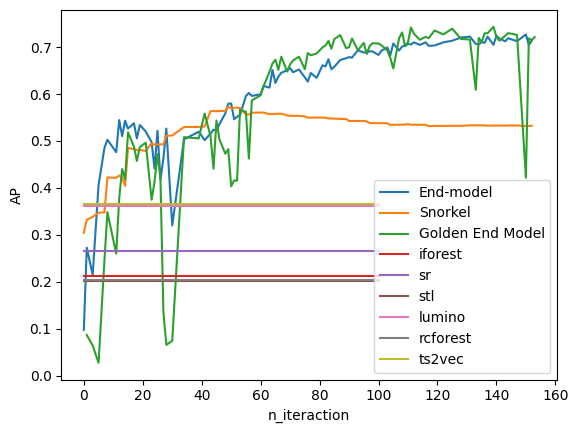

In [14]:
# Train
plot_exp(end_model_ap_history, snorkel_ap_history, only_end_model_ap_history, uad_ap_dict)

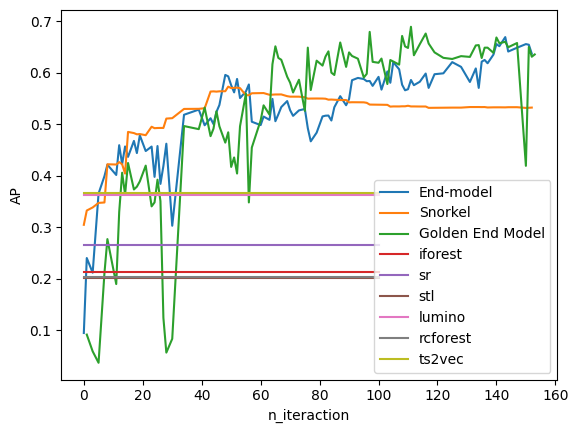

In [15]:
# Test
plot_exp(end_model_test_ap_history, snorkel_ap_history, only_end_model_test_ap_history, uad_ap_dict)

# Ablation: LF Generator

In [16]:
wo_active_learning = False
wo_lf_generator = True

# init golden labels
golden_labels = index_pd.copy()
golden_labels[:] = ABSTAIN

# flag for changing ws model from snorkel to majority voting
mv_flag = False
n_iter = 0
n_interact = 0

# history record
snorkel_ap_history = []
snorkel_auc_history=[]
end_model_ap_history = []
end_model_auc_history=[]
only_end_model_ap_history = []
only_end_model_auc_history=[]
end_model_test_ap_history = []
end_model_test_auc_history=[]
only_end_model_test_ap_history = []
only_end_model_test_auc_history=[]

LFs = LFs_init.copy()

In [17]:
num_epoch = 100

for i in range(num_epoch):
    LFs = loop(LFs)

 ******* 0 th iteration ******* 
-----WEAK SUPERVISION-----
【AP】: 0.30437473260073206 【AUC】: 0.8805199315802117
-----END MODEL-----
TRAIN【AP】: 0.0974837490187023 【AUC】: 0.903190324818163
TEST 【AP】: 0.09411495147631874 【AUC】: 0.8926393575522342
-----ACTIVE LEARNING-----
Top 5 [('yahoo_174', 1202), ('yahoo_263', 727), ('yahoo_264', 1200), ('yahoo_182', 970), ('yahoo_360', 791)]
-----HUMAN LABELING-----
6 anomalies are labeled in yahoo_174 1202
-----GOLDEN LABEL MODEL-----
Up to now labeled 6 anomaly ( 0.209 %)
TRAIN【AP】: 0.3752251225303978 【AUC】: 0.865047257722143
TEST 【AP】: 0.2876397192952102 【AUC】: 0.7721305863890149
-----LF GENERATOR-----
w/o LF Generator
 ******* 1 th iteration ******* 
-----WEAK SUPERVISION-----
【AP】: 0.3052153664848171 【AUC】: 0.8803844038470637
-----END MODEL-----
TRAIN【AP】: 0.1633193697016478 【AUC】: 0.9012737969852628
TEST 【AP】: 0.1401151406104068 【AUC】: 0.8785735281146296
-----ACTIVE LEARNING-----
Top 5 [('yahoo_43', 20), ('yahoo_57', 1209), ('yahoo_37', 1413), (

【AP】: 0.5030787093918005 【AUC】: 0.9062077196293115
-----END MODEL-----
TRAIN【AP】: 0.5796253279956632 【AUC】: 0.8803418537004526
TEST 【AP】: 0.4817143865832095 【AUC】: 0.855743594850052
-----ACTIVE LEARNING-----
Top 5 [('yahoo_21', 1350), ('yahoo_353', 337), ('yahoo_72', 361), ('yahoo_21', 1422), ('yahoo_181', 258)]
-----HUMAN LABELING-----
1 anomalies are labeled in yahoo_21 1350
-----GOLDEN LABEL MODEL-----
Up to now labeled 85 anomaly ( 2.954 %)
TRAIN【AP】: 0.4659518767056894 【AUC】: 0.8615325261912621
TEST 【AP】: 0.3574755982934801 【AUC】: 0.875294034189281
-----LF GENERATOR-----
w/o LF Generator
 ******* 13 th iteration ******* 
-----WEAK SUPERVISION-----
【AP】: 0.5028298211719434 【AUC】: 0.9060845120041786
-----END MODEL-----
TRAIN【AP】: 0.5677824289952577 【AUC】: 0.9171263218872944
TEST 【AP】: 0.4767687387328936 【AUC】: 0.8656798285689812
-----ACTIVE LEARNING-----
Top 5 [('yahoo_22', 0), ('yahoo_85', 1210), ('yahoo_44', 115), ('yahoo_285', 28), ('yahoo_118', 83)]
-----HUMAN LABELING-----
No a

TRAIN【AP】: 0.6227811308165969 【AUC】: 0.9042432727203327
TEST 【AP】: 0.539193338454952 【AUC】: 0.8845673516944139
-----ACTIVE LEARNING-----
Top 5 [('yahoo_197', 1516), ('yahoo_215', 1106), ('yahoo_238', 427), ('yahoo_201', 1422), ('yahoo_275', 289)]
-----HUMAN LABELING-----
1 anomalies are labeled in yahoo_197 1516
-----GOLDEN LABEL MODEL-----
Up to now labeled 151 anomaly ( 5.249 %)
TRAIN【AP】: 0.6173721218680331 【AUC】: 0.8728940060209504
TEST 【AP】: 0.5299872233362227 【AUC】: 0.8839527479866449
-----LF GENERATOR-----
w/o LF Generator
 ******* 25 th iteration ******* 
-----WEAK SUPERVISION-----
【AP】: 0.5313609218911789 【AUC】: 0.9163429138793312
-----END MODEL-----
TRAIN【AP】: 0.6386793646008153 【AUC】: 0.9056558525848868
TEST 【AP】: 0.5271560043314973 【AUC】: 0.8320623787144926
-----ACTIVE LEARNING-----
Top 5 [('yahoo_337', 667), ('yahoo_243', 1373), ('yahoo_251', 978), ('yahoo_316', 677), ('yahoo_233', 548)]
-----HUMAN LABELING-----
3 anomalies are labeled in yahoo_337 667
-----GOLDEN LABEL MO

【AP】: 0.5420364829668036 【AUC】: 0.9237275227282798
-----END MODEL-----
TRAIN【AP】: 0.6505993254729379 【AUC】: 0.9098578291769075
TEST 【AP】: 0.5418340295247823 【AUC】: 0.9030705406446927
-----ACTIVE LEARNING-----
Top 5 [('yahoo_31', 1258), ('yahoo_320', 622), ('yahoo_131', 894), ('yahoo_146', 896), ('yahoo_323', 27)]
-----HUMAN LABELING-----
34 anomalies are labeled in yahoo_31 1258
-----GOLDEN LABEL MODEL-----
Up to now labeled 242 anomaly ( 8.412 %)
TRAIN【AP】: 0.6605169165796252 【AUC】: 0.9229316616673814
TEST 【AP】: 0.5972310363960974 【AUC】: 0.9029869785545537
-----LF GENERATOR-----
w/o LF Generator
 ******* 37 th iteration ******* 
-----WEAK SUPERVISION-----
【AP】: 0.5454877543726597 【AUC】: 0.9244264223547114
-----END MODEL-----
TRAIN【AP】: 0.6760775394912937 【AUC】: 0.9148219560886904
TEST 【AP】: 0.5615914689813539 【AUC】: 0.8813453007837265
-----ACTIVE LEARNING-----
Top 5 [('yahoo_195', 762), ('yahoo_55', 285), ('yahoo_26', 1306), ('yahoo_2', 1250), ('yahoo_42', 1018)]
-----HUMAN LABELING--

TRAIN【AP】: 0.7161585397385456 【AUC】: 0.9304614643678258
TEST 【AP】: 0.609697358165059 【AUC】: 0.9267111534286611
-----LF GENERATOR-----
w/o LF Generator
 ******* 58 th iteration ******* 
-----WEAK SUPERVISION-----
【AP】: 0.5746158683889057 【AUC】: 0.9365786896580843
-----END MODEL-----
TRAIN【AP】: 0.7261086200417495 【AUC】: 0.9492076454943152
TEST 【AP】: 0.6379175529392582 【AUC】: 0.9359430316905674
-----ACTIVE LEARNING-----
Top 5 [('yahoo_11', 1356), ('yahoo_61', 290), ('yahoo_11', 1358), ('yahoo_312', 508), ('yahoo_188', 155)]
-----HUMAN LABELING-----
78 anomalies are labeled in yahoo_11 1356
-----GOLDEN LABEL MODEL-----
Up to now labeled 428 anomaly ( 14.877 %)
TRAIN【AP】: 0.7386387446709662 【AUC】: 0.9234517221509877
TEST 【AP】: 0.5343426081150311 【AUC】: 0.9343144575871427
-----LF GENERATOR-----
w/o LF Generator
 ******* 59 th iteration ******* 
-----WEAK SUPERVISION-----
【AP】: 0.5795411160802632 【AUC】: 0.9401148731812801
-----END MODEL-----
TRAIN【AP】: 0.7634222955727878 【AUC】: 0.956661518237

TEST 【AP】: 0.5641798216490853 【AUC】: 0.9557050057604102
-----LF GENERATOR-----
w/o LF Generator
 ******* 70 th iteration ******* 
-----WEAK SUPERVISION-----
【AP】: 0.6011245148378859 【AUC】: 0.9470900685356998
-----END MODEL-----
TRAIN【AP】: 0.7624902246370997 【AUC】: 0.9381249797964628
TEST 【AP】: 0.6303690928708158 【AUC】: 0.9135580229001007
-----ACTIVE LEARNING-----
Top 5 [('yahoo_2', 1250), ('yahoo_224', 1358), ('yahoo_300', 747), ('yahoo_58', 1386), ('yahoo_214', 1251)]
-----HUMAN LABELING-----
13 anomalies are labeled in yahoo_2 1250
-----GOLDEN LABEL MODEL-----
Up to now labeled 475 anomaly ( 16.51 %)
TRAIN【AP】: 0.7401027211499657 【AUC】: 0.9406390324590397
TEST 【AP】: 0.5617422868822908 【AUC】: 0.9456717612332871
-----LF GENERATOR-----
w/o LF Generator
 ******* 71 th iteration ******* 
-----WEAK SUPERVISION-----
【AP】: 0.6011524770469925 【AUC】: 0.9471093030067465
-----END MODEL-----
TRAIN【AP】: 0.7598820065372264 【AUC】: 0.8896177263477996
TEST 【AP】: 0.6401784306941457 【AUC】: 0.91239014014

【AP】: 0.6190520132793949 【AUC】: 0.9540541173789532
-----END MODEL-----
TRAIN【AP】: 0.7784425761267519 【AUC】: 0.9163427314379947
TEST 【AP】: 0.6285890131236188 【AUC】: 0.9194767786731677
-----ACTIVE LEARNING-----
Top 5 [('yahoo_241', 6), ('yahoo_81', 625), ('yahoo_356', 69), ('yahoo_6', 1305), ('yahoo_118', 1201)]
-----HUMAN LABELING-----
2 anomalies are labeled in yahoo_241 6
-----GOLDEN LABEL MODEL-----
Up to now labeled 663 anomaly ( 23.045 %)
TRAIN【AP】: 0.7815362472280405 【AUC】: 0.9489161005569261
TEST 【AP】: 0.594979443464832 【AUC】: 0.9544507419008667
-----LF GENERATOR-----
w/o LF Generator
 ******* 83 th iteration ******* 
-----WEAK SUPERVISION-----
【AP】: 0.6191687660316978 【AUC】: 0.9540916033467601
-----END MODEL-----
TRAIN【AP】: 0.7907399931963754 【AUC】: 0.9284515261615411
TEST 【AP】: 0.6351795878184272 【AUC】: 0.9277490905634374
-----ACTIVE LEARNING-----
Top 5 [('yahoo_318', 1540), ('yahoo_184', 9), ('yahoo_201', 620), ('yahoo_193', 723), ('yahoo_28', 1286)]
-----HUMAN LABELING-----
N

Top 5 [('yahoo_275', 1070), ('yahoo_236', 235), ('yahoo_307', 474), ('yahoo_113', 663), ('yahoo_299', 505)]
-----HUMAN LABELING-----
1 anomalies are labeled in yahoo_275 1070
-----GOLDEN LABEL MODEL-----
Up to now labeled 708 anomaly ( 24.609 %)
TRAIN【AP】: 0.7907005255554705 【AUC】: 0.9477310622636513
TEST 【AP】: 0.6776117859577719 【AUC】: 0.933057401781853
-----LF GENERATOR-----
w/o LF Generator
 ******* 95 th iteration ******* 
-----WEAK SUPERVISION-----
【AP】: 0.6284433649473415 【AUC】: 0.9582337948127219
-----END MODEL-----
TRAIN【AP】: 0.7962424818708054 【AUC】: 0.933287224598912
TEST 【AP】: 0.646950962978681 【AUC】: 0.8977514135976651
-----ACTIVE LEARNING-----
Top 5 [('yahoo_323', 93), ('yahoo_323', 116), ('yahoo_219', 17), ('yahoo_322', 1204), ('yahoo_216', 24)]
-----HUMAN LABELING-----
No anomaly is annotated in yahoo_323 93
1 anomalies are labeled in yahoo_219 17
-----GOLDEN LABEL MODEL-----
Up to now labeled 709 anomaly ( 24.644 %)
TRAIN【AP】: 0.7865567286040909 【AUC】: 0.939701669324812

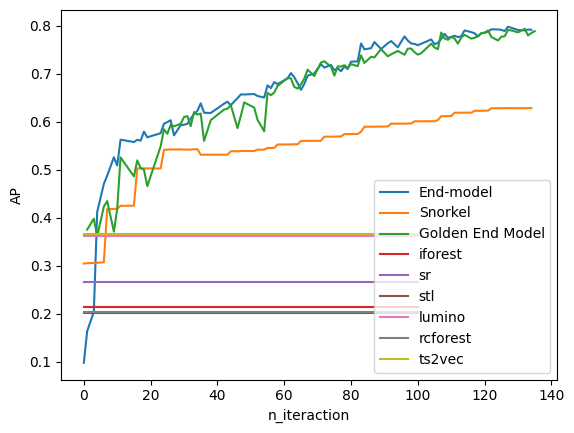

In [18]:
# Train
plot_exp(end_model_ap_history, snorkel_ap_history, only_end_model_ap_history, uad_ap_dict)

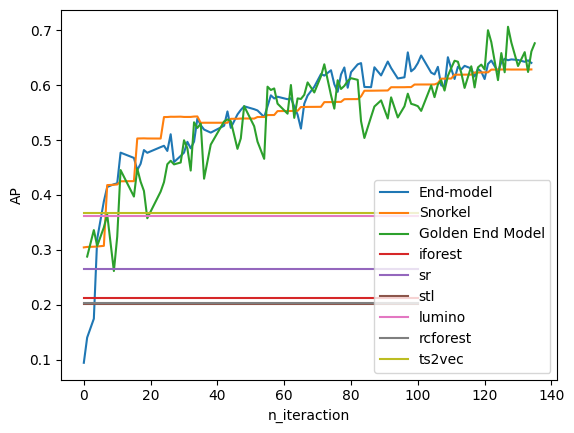

In [19]:
# Test
plot_exp(end_model_test_ap_history, snorkel_ap_history, only_end_model_test_ap_history, uad_ap_dict)